In [1]:
%pip install -U -q langchain>=0.2.5 langchain-community>=0.2.0 langchain-text-splitters>=0.2.0 langchain-google-genai>=0.0.10 chromadb>=0.5.0 tiktoken>=0.7.0 pypdf>=4 python-dotenv>=1.0.1

Note: you may need to restart the kernel to use updated packages.


## 2. Importamos las librerías necesarias

⏱️ **Tiempo estimado: 1 minuto**

### Desglose de importaciones:
- **PyPDFLoader**: Lee PDFs
- **RecursiveCharacterTextSplitter**: Divide el texto en chunks (trozos)
- **Chroma**: Vector database para almacenar embeddings
- **GoogleGenerativeAIEmbeddings**: Convierte texto en vectores
- **ChatGoogleGenerativeAI**: Modelo de lenguaje Gemini
- **tqdm**: Barra de progreso

In [2]:
import os
from pathlib import Path
from typing import List, Literal

from dotenv import load_dotenv
load_dotenv()  # Carga variables de entorno (GOOGLE_API_KEY, etc.)

# LangChain loaders, splitters, vectorstore, LLM/embeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

# Embeddings y modelo de chat con Google Gemini
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

# Utilidad
from tqdm import tqdm

## 3. Configuramos el entorno

⏱️ **Tiempo estimado: 3-5 minutos**

### Conceptos clave:
- **CHUNK_SIZE**: Tamaño de cada fragmento de texto (ej: 1000 caracteres)
- **CHUNK_OVERLAP**: Solapamiento entre chunks (ej: 200 caracteres) para mantener contexto
- **TOP_K**: Número de documentos más relevantes a recuperar
- **Modelos**: Necesitas elegir embeddings y modelo de chat

💡 **Tip**: Valores típicos:
- CHUNK_SIZE: 500-2000
- CHUNK_OVERLAP: 100-400 (~20% del CHUNK_SIZE)
- Embedding: "models/text-embedding-004"
- Chat: "gemini-2.5-flash" o "gemini-1.5-pro"

In [3]:
# 🛠️ Configuración
PDF_DIR = Path("./docs")             # <- Carpeta con PDFs
PERSIST_DIR = Path("./chroma_pdfs_gemini")  # Donde se guardará Chroma
PERSIST_DIR.mkdir(parents=True, exist_ok=True)

# Valores completados para prueba
CHUNK_SIZE = 800  # Tamaño de cada chunk (trozo) de texto. Rango: 500-2000
CHUNK_OVERLAP = 120  # Solapamiento entre chunks. Recomendado: ~20% del CHUNK_SIZE
TOP_K = 4  # Número de documentos recuperados (mantén este valor)

# Modelos de Gemini
EMBEDDING_MODEL = "models/text-embedding-004"  # Modelo de embeddings
CHAT_MODEL = "gemini-2.5-flash"  # Modelo de chat

# Verificar clave - SIN ESTO, NO FUNCIONA
assert os.getenv("GOOGLE_API_KEY"), "❌ Falta GOOGLE_API_KEY en variables de entorno o .env"
print(f"✅ GOOGLE_API_KEY detectada")
print(f"📁 Carpeta PDFs: {PDF_DIR.resolve()}")
print(f"🗂️  Persistencia Chroma: {PERSIST_DIR.resolve()}")
print(f"🔧 Configuración: CHUNK_SIZE={CHUNK_SIZE}, OVERLAP={CHUNK_OVERLAP}, TOP_K={TOP_K}")

✅ GOOGLE_API_KEY detectada
📁 Carpeta PDFs: C:\Trainings\GenIA_trainings\Training\docs
🗂️  Persistencia Chroma: C:\Trainings\GenIA_trainings\Training\chroma_pdfs_gemini
🔧 Configuración: CHUNK_SIZE=800, OVERLAP=120, TOP_K=4


## 4. Cargamos los PDFs

⏱️ **Tiempo estimado: 5-10 minutos** (según cantidad de PDFs)

### ¿Qué ocurre aquí?
1. Lee todos los PDFs de la carpeta `./docs`
2. Añade metadatos (origen del documento) a cada página
3. Retorna lista de documentos cargados

🎯 **Objetivo**: Tener una lista de documentos listos para procesar

💡 **Tip de debugging**: Si no ves docs, verifica que:
- Los PDFs están en `./docs`
- Los PDFs no están corruptos
- Tienes permisos de lectura

In [4]:
def load_pdfs_from_dir(directory: Path, recursive: bool = True):
    """Carga todos los PDFs de una carpeta de forma recursiva."""
    pattern = "**/*.pdf" if recursive else "*.pdf"
    pdf_paths = sorted([p for p in directory.glob(pattern) if p.is_file()])
    all_docs = []
    for pdf in tqdm(pdf_paths, desc="Cargando PDFs"):
        try:
            docs = PyPDFLoader(str(pdf)).load()
            # Añadimos metadatos útiles
            for d in docs:
                d.metadata = d.metadata or {}
                d.metadata["source"] = str(pdf.resolve())
            all_docs.extend(docs)
        except Exception as e:
            print(f"⚠️ Error leyendo {pdf}: {e}")
    print(f"📚 Documentos (páginas) cargados: {len(all_docs)}")
    return all_docs

raw_docs = load_pdfs_from_dir(PDF_DIR, recursive=True)

Cargando PDFs: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

📚 Documentos (páginas) cargados: 221


## 5. Chunking.

⏱️ **Tiempo estimado: 1-2 minutos**

### ¿Por qué hacer chunking?
- Los modelos tienen límite de tokens (palabras)
- Dividir en trozos permite recuperar partes relevantes
- El solapamiento preserva contexto entre chunks

### Parámetros de recursión:
- `separators=["\n\n", "\n", " ", ""]` → Intenta respetar párrafos, luego líneas, luego palabras


In [5]:
# Crea el splitter con los parámetros configurados
splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    separators=["\n\n", "\n", " ", ""],
)
chunks = splitter.split_documents(raw_docs)
print(f"✂️  Chunks generados: {len(chunks)}")
print(f"📈 Ratio de expansión: {len(chunks)} chunks de {len(raw_docs)} documentos")
if chunks:
    print(f"📝 Ejemplo de primer chunk (primeros 200 caracteres):\n{chunks[0].page_content[:200]}...")

✂️  Chunks generados: 501
📈 Ratio de expansión: 501 chunks de 221 documentos
📝 Ejemplo de primer chunk (primeros 200 caracteres):
Lava 600 - Primary
#FF3621
RGB (255 ,54, 33)
C0, M91, Y93, K0
Navy 800 - Primary
#1B3139
RGB (27, 49, 57)
C86, M65, Y57, K56
Maroon 600
#98102A
RGB (152, 16, 42)
C26, M100, Y84, K24
Yellow 600
#FFAB00...


## 6. Crear Embeddings y Vector Store

⏱️ **Tiempo estimado: 5-15 minutos** (según cantidad de chunks)

### Conceptos:
- **Embeddings**: Convertir texto a números (vectores)
  - El modelo de embeddings crea una representación numérica
  - Textos similares tienen vectores cercanos
- **Vector Store (Chroma)**: Base de datos de vectores
  - Almacena chunks + sus embeddings
  - Permite búsqueda semántica rápida
- **Retriever**: Interfaz para recuperar documentos similares

💡 **Pista**: Este paso es intensivo. Es normal esperar.

🎯 **Prueba de checkpoint**: El vector store debe persistirse en `./chroma_pdfs_gemini`

In [6]:
# Crea los embeddings con el modelo configurado
embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL)
print("✅ Embeddings inicializados")

# Crea el vector store con Chroma
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory=str(PERSIST_DIR),
)
print(f"✅ Vector store creado con {len(chunks)} chunks")

# Crea el retriever a partir del vector store
retriever = vectorstore.as_retriever(search_kwargs={"k": TOP_K})
print("✅ Retriever creado y listo para búsquedas")

✅ Embeddings inicializados
✅ Vector store creado con 501 chunks
✅ Retriever creado y listo para búsquedas


## 7. Creamos la Tool (Retriever) para el agente

⏱️ **Tiempo estimado: 2 minutos**

### ¿Qué es una Tool?
Una herramienta que el agente puede usar durante su ejecución:
- **Nombre**: Identificador único
- **Descripción**: Qué hace (el modelo la lee para decidir si usarla)
- **Función**: El retriever que implementa la búsqueda

💡 **Pista**: Una buena descripción ayuda al modelo a saber cuándo usar esta herramienta.

In [7]:
from langchain_core.tools.retriever import create_retriever_tool

# Crea la retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "pdf_search",  # nombre de la tool
    "Busca información en los PDFs cargados. Útil para encontrar respuestas sobre documentos PDF.",  # descripción
)

print(f"✅ Retriever tool '{retriever_tool.name}' creada")
print(f"   Descripción: {retriever_tool.description}")

✅ Retriever tool 'pdf_search' creada
   Descripción: Busca información en los PDFs cargados. Útil para encontrar respuestas sobre documentos PDF.


### 7.1 Test de la tool

⏱️ **Tiempo estimado: 2 minutos**

**Objetivo**: Verificar que la tool funciona correctamente
- Ejecuta una búsqueda real contra tu vector store
- Observa qué documentos se recuperan
- Valida que son relevantes

In [8]:
# Prueba la tool con una pregunta sobre tus PDFs
resultado=retriever_tool.invoke({"query": "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que es un deployment tipo batch?"})
print("\n📄 Documentos recuperados:")
print("-" * 60)
print(resultado)


📄 Documentos recuperados:
------------------------------------------------------------
Lava 500
#FF5F46
RGB (255, 95, 70)
C0, M78, Y79, K0
Navy 900
#0B2026
RGB (11, 32, 38)
C86, M67, Y61,  K71
© Databricks 2025. All rights reserved. Apache, Apache Spark, Spark, the Spark Logo, Apache Iceberg, Iceberg, and the Apache 
Iceberg logo are trademarks of the Apache Software Foundation.
Batch Deployment
● Batch processing generates predictions on a regular schedule and 
writes the results out to persistent storage to be consumed downstream 
(i.e. ad-hoc BI).
● Batch deployment is the simplest deployment strategy.
● Ideal for cases when: 
○ Immediate predictions is not necessary
○ Predictions can be made in batch fashion
○ Number/volume of (new) records/observations to predict is large
○ Pace at which input/records change or is received is > 30 mins

Lava 500
#FF5F46
RGB (255, 95, 70)
C0, M78, Y79, K0
Navy 900
#0B2026
RGB (11, 32, 38)
C86, M67, Y61,  K71
© Databricks 2025. All rights reserved.

## 8. Nodo: Genera query o responde directamente

⏱️ **Tiempo estimado: 5 minutos**

### Flujo del agente (agentico loop):
1. **Este nodo**: Recibe la pregunta del usuario
2. Decide: ¿Necesito buscar docs o puedo responder directamente?
3. Si usa la tool → pasa a retriever
4. Si responde → termina

### Conceptos clave:
- **bind_tools**: Conecta herramientas al modelo
- **MessagesState**: Estado que mantiene el historial de mensajes
- **ToolUse**: Cuando el modelo elige usar una herramienta

💡 **Pista**: Es el primer nodo del grafo agentico

In [9]:
from langgraph.graph import MessagesState

# Instancia el modelo de chat con el modelo configurado
response_model = ChatGoogleGenerativeAI(model=CHAT_MODEL, temperature=0)
print(f"✅ Modelo de chat {CHAT_MODEL} configurado")

def genera_query_o_responde(state: MessagesState):
    """Nodo 1: Decide si recuperar información o responder directamente."""
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

✅ Modelo de chat gemini-2.5-flash configurado


### 8.1 Test: Pregunta que no necesita búsqueda

⏱️ **Tiempo estimado: 1 minuto**

**Esperado**: El modelo responde directamente sin usar la tool
- Pregunta genérica (ej: "¿Cuanto vale una cortina?")
- Observa que NO hay tool_use en la respuesta

In [10]:
# Prueba con una pregunta general
input_test = {"messages": [{"role": "user", "content": "¿Cuanto vale una cortina?"}]}
print("\n🧪 Test 1: Pregunta sin necesidad de búsqueda\n")
respuesta = genera_query_o_responde(input_test)
respuesta["messages"][-1].pretty_print()
print("\n✅ Observa que NO hay 'tool_use' en la respuesta")


🧪 Test 1: Pregunta sin necesidad de búsqueda

================================== Ai Message ==================================

[{'type': 'text', 'text': 'No tengo información sobre el precio de las cortinas. Mi función es buscar información en los PDFs que me has proporcionado. Si la información que buscas está en alguno de ellos, por favor, házmelo saber.', 'extras': {'signature': 'CogFAdHtim+k0VBxDVhKGUJv2Lg5d3qVEXgXND3WXzX3MjtnZyNt5Wm830vUSX4LACvh0bYzd3i4hLxQbGE8jDVS9o4FCgRBOOPOaPLd7hkcdT1Jc2x1ZIaKOs7P7+tQS4ai3fk0nh6xlAXVWvpuhz7TxDsU5zCUBlfaMx5b/IJuPhGK8S277TI8GVtpLv/fTNlNAcgXvUX5gqchnALIUeZMWuWA0octMY2b4QIDheIIvABP7LUshzD9WE8J+rhvBIwUJSY4tmSmlJ/27BtNyXztYy0Iz82bmLNaIPtlA1OoPre54CFVHrylJtv6tphvUgg0IXFUVRMTl1ndRWejG/GIas0d5ZyYE85J4xDa9fVlOePgTiHxmotD3aBE6a3N8XksBtqO4AmyASGz4Vj/P4E31pvbn0PYt9u+b6XX4gA/HlPr0PyaR+pYwK8ZPQCuqZJQIfkSX1VWkAPj4T1O15zvxY+3LooB/Va/gqEokyUdLlKm/TYbEOf8f37L0S46SIDQM+Z0ezl34mqxQD/dt7d1aTztDR8FKXnTtuXeLshGbNoM7T3n5iFcO2Q8+xAO0ky1qhRN/snWvOy0w1ctkxO+qQqQqXng+4md

### 8.2 Test: Pregunta que requiere búsqueda semántica

⏱️ **Tiempo estimado: 1 minuto**

**Esperado**: El modelo usa la tool para buscar documentos
- Pregunta sobre contenido de tus PDFs
- Observa que SÍ hay tool_use con el nombre de tu tool

In [11]:
# Prueba con una pregunta que REQUIERE búsqueda
input_test = {
    "messages": [
        {
            "role": "user",
            "content": "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que es un deployment tipo batch?",
            #"content": "¿Que es un  batch?",
        }
    ]
}
print("\n🧪 Test 2: Pregunta que REQUIERE búsqueda\n")
respuesta = genera_query_o_responde(input_test)
respuesta["messages"][-1].pretty_print()
print("\n✅ Observa que SÍ hay 'tool_use' (tu tool debe estar en tool_calls)")


🧪 Test 2: Pregunta que REQUIERE búsqueda

================================== Ai Message ==================================
Tool Calls:
  pdf_search (c5629370-7ffc-423a-9935-5ccace5fee35)
 Call ID: c5629370-7ffc-423a-9935-5ccace5fee35
  Args:
    query: ¿Que es un deployment tipo batch?

✅ Observa que SÍ hay 'tool_use' (tu tool debe estar en tool_calls)


## 9. Nodo: Evaluar relevancia de documentos

⏱️ **Tiempo estimado: 5 minutos**

### ¿Por qué evaluar relevancia?
- No siempre la búsqueda semántica recupera docs relevantes
- Control de calidad: rechazar docs no pertinentes
- Bifurcación: docs relevantes → responder, docs irrelevantes → reescribir pregunta

### GradeDocuments (Pydantic):
- Estructura de datos con score binario ("si"/"no")
- Ayuda a parsear la respuesta del modelo

💡 **Concepto**: Los modelos pueden ser instructores, pero también evaluadores

In [12]:
from pydantic import BaseModel, Field

GRADE_PROMPT = (
    "Eres un evaluador que determina la relevancia de un documento recuperado respecto a una pregunta del usuario. \n "
    "Aquí tienes el documento recuperado: \n\n {context} \n\n"
    "Aquí tienes la pregunta del usuario: {question} \n"
    "Si el documento contiene palabra(s) clave o significado semántico relacionado con la pregunta del usuario, califícalo como relevante. \n"
    "Da una puntuación binaria 'si' o 'no' para indicar si el documento es relevante para la pregunta."
)

class GradeDocuments(BaseModel):
    """Califica los documentos utilizando una puntuación binaria para comprobar su relevancia"""
    binary_score: str = Field(
        description="Puntuación : 'si' si es relevante, o 'no' si no lo es"
    )

grader_model = ChatGoogleGenerativeAI(model=CHAT_MODEL, temperature=0)

def grade_documents(state: MessagesState) -> Literal["genera_respuesta", "rescribir_question"]:
    """Nodo 2: Evalúa si los documentos recuperados son relevantes.
    
    Retorna:
    - "genera_respuesta" si docs son relevantes
    - "rescribir_question" si no lo son
    """
    print("\n⏳ Evaluando relevancia de documentos...")
    
    # Extrae la pregunta
    question = state["messages"][0].content
    
    # Extrae el contexto (última respuesta)
    context = state["messages"][-1].content
    
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print(f"📊 Score de relevancia: {score}")
    
    if score == "si":
        print("✅ Docs relevantes → generando respuesta")
        return "genera_respuesta"
    else:
        print("❌ Docs no relevantes → reescribiendo pregunta")
        return "rescribir_question"

#### 9.1 Comprobamos con una respuesta irrelevante

In [13]:
#simulamos la respuesta de la tool mediante mensajes
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Que es un deployment batch?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Que es un deployment batch?"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}


grade_documents(input)


⏳ Evaluando relevancia de documentos...
📊 Score de relevancia: no
❌ Docs no relevantes → reescribiendo pregunta


'rescribir_question'

#### 9.2 Comprobar que el documento/respuesta relevante lo clasifica como tal

In [14]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
               
                "content": "¿Que es un deployment batch en el documento?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Que es un deployment batch en el documento?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "El contexto proporcionado hace referencia a 'batch deployment' (despliegue por lotes) en el documento, pero no ofrece una definición explícita de qué es 'batch'. Sin embargo, se menciona que uno de los objetivos de aprendizaje es describir el despliegue en batch y sus escenarios de uso, así como identificar las ventajas y desventajas de desplegar un modelo mediante procesamiento por lotes, y discutir un flujo de trabajo típico para este tipo de despliegue en Databricks.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)


⏳ Evaluando relevancia de documentos...
📊 Score de relevancia: si
✅ Docs relevantes → generando respuesta


'genera_respuesta'

## 10. Nodo: Rescribir la pregunta si no es lo suficientemente clara

⏱️ **Tiempo estimado: 3 minutos**

### Flujo iterativo:
Si los docs no son relevantes:
1. Reescribir pregunta (mejorar redacción)
2. Volver a generar query
3. Buscar de nuevo
4. Evaluar de nuevo

💡 **Concepto**: Query rewriting → búsqueda mejorada → mejor contexto

⚠️ **Nota**: En un grafo real habría límite de iteraciones para evitar loops infinitos

In [15]:
REWRITE_PROMPT = (
    "Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.\n"
    "Pregunta original:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:"
)

def rescribir_question(state: MessagesState):
    """Nodo 3: Reescribe la pregunta del usuario para mejorarla."""
    print("\n✏️  Reescribiendo pregunta para mejorar búsqueda...")
    messages = state["messages"]
    
    # Extrae la pregunta original
    question = messages[0].content
    
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    
    print(f"📝 Pregunta reescrita: {response.content[:100]}...")
    return {"messages": [{"role": "user", "content": response.content}]}

### 10.1 Probamos la función de rescribir la pregunta

In [16]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Que es batch?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Que es batch?"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},#respuesta absurda
        ]
    )
}

response = rescribir_question(input)
print(response["messages"][-1]["content"])


✏️  Reescribiendo pregunta para mejorar búsqueda...
📝 Pregunta reescrita: La pregunta original "¿Qué es batch?" es demasiado ambigua debido a que la palabra "batch" tiene múl...
La pregunta original "¿Qué es batch?" es demasiado ambigua debido a que la palabra "batch" tiene múltiples significados dependiendo del contexto (informática, producción, química, etc.). La intención profunda es, probablemente, obtener una definición o explicación de "batch" en un contexto específico que el usuario tiene en mente, pero que no ha explicitado.

Para hacerla más clara, precisa y fácil de entender, necesitamos añadir contexto o pedir al usuario que lo especifique.

Aquí tienes varias opciones, dependiendo del contexto más probable o de cómo quieras guiar al usuario:

**Opción 1 (La más completa, pidiendo contexto):**

> "Para poder responder con precisión, ¿podrías especificar el contexto en el que te refieres a 'batch'? Por ejemplo, ¿estás preguntando sobre:
>
> *   El concepto de **procesamiento

## 11. Nodo: Generar la respuesta final

⏱️ **Tiempo estimado: 3 minutos**

### Última etapa del RAG:
1. Tienes documentos relevantes (ya evaluados)
2. Tienes la pregunta del usuario
3. Formato de prompt: pregunta + contexto
4. Modelo genera respuesta basada en docs

💡 **Prompt engineering**: El GENERATE_PROMPT es crucial
- Limita respuesta a 3 frases (concisión)
- Pide admitir ignorancia ("si no sabes, di que no sabes")

### 11.1 Construimos el nodo generate_answer

In [17]:
GENERATE_PROMPT = (
    "Eres un asistente para tareas de preguntas y respuestas. "
    "Utiliza los siguientes fragmentos de contexto recuperado para responder a la pregunta. "
    "Si no sabes la respuesta, simplemente indica que no la sabes. "
    "Utiliza un máximo de tres frases y mantén la respuesta concisa.\n"
    "Pregunta: {question} \n"
    "Contexto: {context}"
)

def genera_respuesta(state: MessagesState):
    """Nodo 4: Genera la respuesta final basada en el contexto relevante."""
    print("\n🤖 Generando respuesta final...")
    
    # Extrae la pregunta
    question = state["messages"][0].content
    
    # Extrae el contexto (último mensaje)
    context = state["messages"][-1].content
    
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    
    print(f"\n✅ Respuesta generada: {response.content[:150]}...")
    return {"messages": [response]}

### 11.2 Comprobamos el metodo de generar respuesta

In [18]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Qué significa el término 'batch deployment en databricks' y en qué contextos se utiliza?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Qué significa el término 'batch deployment en databriccks' y en qué contextos se utiliza?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "El contexto proporcionado hace referencia a 'batch deployment' (despliegue por lotes) en el documento, pero no ofrece una definición explícita de qué es 'batch'. Sin embargo, se menciona que uno de los objetivos de aprendizaje es describir el despliegue en batch y sus escenarios de uso, así como identificar las ventajas y desventajas de desplegar un modelo mediante procesamiento por lotes, y discutir un flujo de trabajo típico para este tipo de despliegue en Databricks",
                "tool_call_id": "1",
            },
        ]
    )
}

response = genera_respuesta(input)
response["messages"][-1].pretty_print()


🤖 Generando respuesta final...

✅ Respuesta generada: El contexto proporcionado no ofrece una definición explícita del término 'batch deployment'. Sin embargo, se refiere a él como un método de despliegue...
================================== Ai Message ==================================

El contexto proporcionado no ofrece una definición explícita del término 'batch deployment'. Sin embargo, se refiere a él como un método de despliegue de modelos en Databricks. Los objetivos de aprendizaje relacionados incluyen describir sus escenarios de uso, identificar sus ventajas y desventajas, y discutir un flujo de trabajo típico para este tipo de despliegue.


## 12. Construir el grafo (workflow agentico)

⏱️ **Tiempo estimado: 5-7 minutos**

### Estructura del grafo:
```
START → genera_query_o_responde
         ↓
    ¿Usa tool?
    /        \
  si         no → END
  ↓
retrieve (ejecuta tool)
  ↓
grade_documents (evalúa relevancia)
  /          \
si           no
↓            ↓
genera_respuesta  rescribir_question
↓              ↓
END ←─────────────────────────────┘
```

### Componentes:
- **Nodos**: Funciones que ejecutan lógica
- **Aristas**: Conexiones entre nodos
- **Aristas condicionales**: Decisiones basadas en salida

💡 **Pista**: Los nombres de nodos deben coincidir en todo el código

### 12.1 Importamos los elementos necesarios para construir el grafo

In [19]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#### 12.2. Ensamblamos el workflow

#### 12.2.1 Añadimos los nodos

In [20]:

print("\n🏗️  Construyendo el grafo agentico...\n")

# Crea el StateGraph
workflow = StateGraph(MessagesState)

# Añade los nodos
workflow.add_node("genera_query_o_responde", genera_query_o_responde)  # Nodo 1
workflow.add_node("retrieve", ToolNode([retriever_tool]))  # Ejecutor de tools
workflow.add_node("rescribir_question", rescribir_question)  # Nodo 3
workflow.add_node("genera_respuesta", genera_respuesta)  # Nodo 4



🏗️  Construyendo el grafo agentico...



#### 12.2.2 Añadimos las aristas.

In [21]:
# Arista inicial
workflow.add_edge(START, "genera_query_o_responde")

# Arista condicional: Si usa herramienta
workflow.add_conditional_edges(
    "genera_query_o_responde",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

# Arista condicional desde retrieve
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)

# Aristas simples
workflow.add_edge("genera_respuesta", END)
workflow.add_edge("rescribir_question", "genera_query_o_responde")

print("✅ Grafo construido correctamente")

✅ Grafo construido correctamente


## 13. Compilar el grafo

⏱️ **Tiempo estimado: 1 minuto**

### ¿Qué significa compilar?
Convertir la estructura de nodos/aristas en un ejecutable
- Valida conexiones
- Prepara para ejecución

💡 **Si hay error aquí**: Revisa nombres de nodos, aristas, y tipos de estado

In [22]:
# Compila el grafo
graph = workflow.compile()
print("✅ Grafo compilado y listo para ejecutar")

✅ Grafo compilado y listo para ejecutar


## 14. Visualizar el grafo

⏱️ **Tiempo estimado: 1 minuto**

### Diagrama visual:
- Ayuda a entender el flujo
- Facilita debugging
- Muestra nodos, aristas, condicionales

💡 **Tip**: Si no se visualiza, puede ser problema de dependencias (graphviz)


📊 Visualizando el grafo agentico...



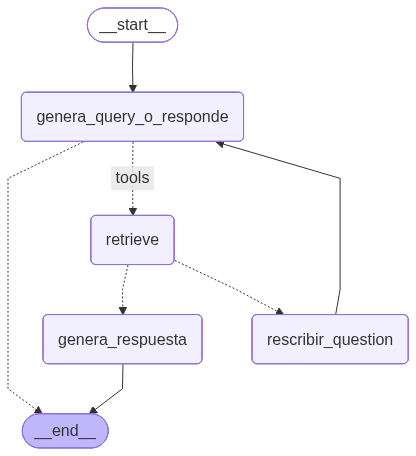

In [23]:
from IPython.display import Image, display

print("\n📊 Visualizando el grafo agentico...\n")

# Visualiza el grafo
display(Image(graph.get_graph().draw_mermaid_png()))

## 15. Ejecutar el grafo - Modo DEBUG

⏱️ **Tiempo estimado: 5-10 minutos** (depende de pregunta)

### Este modo:
- Muestra cada nodo por el que pasa
- Imprime todos los mensajes intermedios
- Útil para debugging y entender el flujo

🎯 **Objetivo**: Ver exactamente cómo se ejecuta el agente

In [24]:
from pprint import pprint

print("\n🚀 Ejecutando el grafo en modo DEBUG...\n")

# Define tu pregunta
pregunta = "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que es un deployment tipo batch?"
print(f"❓ Pregunta: {pregunta}\n")
print("=" * 60)

# Ejecuta el grafo paso a paso
for chunk in graph.stream({"messages": [{"role": "user", "content": pregunta}]}):
    for node, update in chunk.items():
        print(f"\n📘 Nodo ejecutado: {node}")
        print("-" * 60)
        messages = update.get("messages", [])
        if messages:
            last_msg = messages[-1]
            try:
                if hasattr(last_msg, "content"):
                    print("📝 Contenido:")
                    print(last_msg.content[:300] if len(last_msg.content) > 300 else last_msg.content)
                elif hasattr(last_msg, "tool_calls"):
                    print(f"🔧 Tool calls: {[tc.name for tc in last_msg.tool_calls]}")
                else:
                    pprint(last_msg)
            except Exception as e:
                print(f"❌ Error: {str(e)}")
        print("-" * 60)

print("\n" + "=" * 60)
print("✅ Ejecución completada")


🚀 Ejecutando el grafo en modo DEBUG...

❓ Pregunta: Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que es un deployment tipo batch?


📘 Nodo ejecutado: genera_query_o_responde
------------------------------------------------------------
📝 Contenido:

------------------------------------------------------------

⏳ Evaluando relevancia de documentos...
📊 Score de relevancia: si
✅ Docs relevantes → generando respuesta

📘 Nodo ejecutado: retrieve
------------------------------------------------------------
📝 Contenido:
Lava 500
#FF5F46
RGB (255, 95, 70)
C0, M78, Y79, K0
Navy 900
#0B2026
RGB (11, 32, 38)
C86, M67, Y61,  K71
© Databricks 2025. All rights reserved. Apache, Apache Spark, Spark, the Spark Logo, Apache Iceberg, Iceberg, and the Apache 
Iceberg logo are trademarks of the Apache Software Foundation.
Batch
------------------------------------------------------------

🤖 Generando respuesta final...

✅ Respuesta generada: Un deployment tipo batch

## 16. Ejecutar el grafo - Modo PRODUCCIÓN

⏱️ **Tiempo estimado: 5-10 minutos**

### Este modo:
- Solo muestra la respuesta final
- Modo limpio (sin debug)
- Usa formateo Markdown para mejor visualización

🎯 **Objetivo**: Resultado final en forma de usuario

In [25]:
from IPython.display import display, Markdown

print("\n🚀 Ejecutando el grafo en modo PRODUCCIÓN...\n")

# Define tu pregunta
pregunta = "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que són los  flavours de MLFlow?"
print(f"❓ Pregunta: {pregunta}\n")
print("=" * 60)

# Ejecuta el grafo y muestra solo la respuesta final
resultado = graph.invoke({"messages": [{"role": "user", "content": pregunta}]})

print("\n📝 RESPUESTA FINAL:\n")
display(Markdown(resultado["messages"][-1].content))

print("\n" + "=" * 60)
print("✅ Consulta completada")


🚀 Ejecutando el grafo en modo PRODUCCIÓN...

❓ Pregunta: Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que són los  flavours de MLFlow?


⏳ Evaluando relevancia de documentos...


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 28.77460441s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10

📊 Score de relevancia: si
✅ Docs relevantes → generando respuesta

🤖 Generando respuesta final...


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 26.694575349s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1


✅ Respuesta generada: Los "flavours" de MLFlow son diferentes tipos o interfaces de modelos que MLFlow soporta. Permiten registrar, guardar, cargar y desplegar modelos de d...

📝 RESPUESTA FINAL:



Los "flavours" de MLFlow son diferentes tipos o interfaces de modelos que MLFlow soporta. Permiten registrar, guardar, cargar y desplegar modelos de diversas plataformas como PyTorch, TensorFlow, LangChain, entre otras. El `mlflow.pyfunc` es un "flavour" predeterminado para modelos de Python, que sirve como una interfaz general para cargar y usar cualquier modelo de MLFlow Python como una función.


✅ Consulta completada


## 17. Resumen y Conceptos Clave

⏱️ **Tiempo estimado: 5-7 minutos** (discusión/preguntas)

### Flujo RAG Agentico completo:
1. **Cargar** (secs 1-4): Documentos → PDFs
2. **Chunking** (sec 5): Documentos → Chunks (piezas manejables)
3. **Embeddings** (sec 6): Chunks → Vectores (números)
4. **Nodo 1** (sec 8): ¿Buscar o responder?
   - Si buscar → Nodo 2 (retrieve)
   - Si responder → END
5. **Nodo 2** (sec 6-7): Buscar documentos similares
6. **Nodo Evaluador** (sec 9): ¿Son relevantes?
   - Si relevantes → Nodo 4 (responder)
   - Si no → Nodo 3 (reescribir pregunta)
7. **Nodo 3** (sec 10): Mejorar pregunta → Volver a Nodo 1
8. **Nodo 4** (sec 11): Generar respuesta final → END

### Conceptos clave aprendidos:
- **Embeddings**: Representación numérica del texto
- **Vector Store**: Base de datos de búsqueda semántica
- **Agentic Loop**: Ciclo de decisión automático
- **Retrieval Augmented Generation (RAG)**: Mejorar respuestas con contexto
- **Graph State**: Máquina de estados con LangGraph
- **Tool Use**: Modelos pueden llamar herramientas automáticamente

### Tips para mejorar:
1. **Tuning de chunks**: Experimenta con CHUNK_SIZE y CHUNK_OVERLAP
2. **Mejor prompt engineering**: Mejorar GRADE_PROMPT y GENERATE_PROMPT
3. **Multiple retrievers**: Combinar BM25 + Semántico
4. **Caching**: Guardar embeddings calculados
5. **Evaluación**: Metrics como precision@k, NDCG

### Siguientes pasos:
- 🔧 Personaliza los prompts para tu caso de uso
- 📊 Mide la calidad de respuestas (F1-score, BLEU, etc)
- 🚀 Despliega en producción con FastAPI/Streamlit
- 📈 Monitorea performance en tiempo real